<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import sxdm
import id01lib
import numpy as np
import h5py

from h5glance import H5Glance as h5p

In [2]:
path_dset = './data/sample/sample_0001/sample_0001.h5'

In [3]:
viz = sxdm.widgets.bliss.InspectROI(path_dset)
viz.show()

In [4]:
shifts, sxdm_raw, sxdm_shift = sxdm.utils.get_shift(
    path_dset, "mpx1x4_mpx4int", [f"{x}.1" for x in range(1, 6)], return_maps=True, upsample_factor=3
)

  0%|          | 0/4 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=0, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

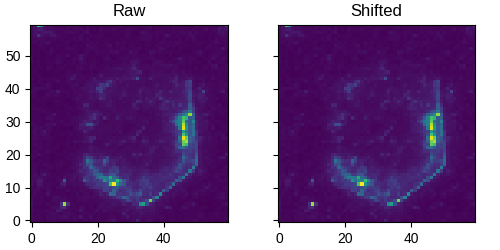

In [5]:
import matplotlib.pyplot as plt
import ipywidgets as ipw

fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True, sharey=True, constrained_layout=True)

im_raw   = ax[0].imshow(sxdm_raw[0], origin='lower')
im_shift = ax[1].imshow(sxdm_shift[0], origin='lower')

ax[0].set_title('Raw')
ax[1].set_title('Shifted')

@ipw.interact(i=(0, len(sxdm_raw)-1, 1))
def compare_raw_and_shifted(i=0):
    im_raw.set_data(sxdm_raw[i])
    im_shift.set_data(sxdm_shift[i])
    
    im_raw.set_clim(sxdm_raw[i].min(), sxdm_raw[i].max())
    im_shift.set_clim(im_raw.get_clim())
    
    fig.canvas.draw()

In [6]:
# %matplotlib widget

# test = sxdm.widgets.bliss.GetShift(path_dset, scan_nos=[f"{x}.1" for x in range(1, 6)])
# test.show()

In [ ]:
class GetShiftContainer(object):
    def __init__(self):
        self.img_idx = 0
        self.img_list = []
        self.img_shifts = [None, None]
        
        self.data = None
        
    def _update_scan(self):
        pass
    
    def _update_norm(self, change):
        # runs when scan idx changed with slider (called by _update_scan)

        islog = change["new"]

        im = self.img
        data = im.get_array()

        if self.fixed_clims is None:
            _clims = [data[data.nonzero()].min(), data.max()]
        else:
            _clims = self.fixed_clims
        self.clims = _clims

        if islog:
            try:
                _ = im.set_norm(mpl.colors.LogNorm(*_clims))
            except ValueError as err:
                print(f"{err}, setting lower bound to 0.1")
                _ = im.set_norm(mpl.colors.LogNorm(0.1, _clims[1]))
        else:
            _ = im.set_norm(mpl.colors.Normalize(*_clims))
    
    def _apply_shift_counter(self):
        pass
    
    def _img_idx_fwd(self, widget):
        try:
            self.img_idx += 1
            self._update_scan({"new": self.img_idx})
        except (IndexError, KeyError):
            self.img_idx -= 1
        self.idxsel.value = self.img_idx

    def _img_idx_bkw(self, widget):

        if self.img_idx > 0:
            self.img_idx -= 1
            self._update_scan({"new": self.img_idx})
        elif self.img_idx < 0:
            self.img_idx += 1
        self.idxsel.value = self.img_idx
        
    def _on_click(self, event):
        with self.figout:
            if event.inaxes == self.ax:
                x, y = event.xdata, event.ydata

                msg = f"You clicked: col={x:.4f}, row={y:.4f}"
                print(f"\r {msg}", flush=True, end="")

                if self.fig.canvas.toolbar.mode == "":
                    self.refmark.set_offsets([x, y])
                    self.marks[self.img_idx] = [x, y]
                else:
                    pass

            else:
                pass
        
    def _init_widgets(self):

        # layout of individual items - css properties
        items_layout = ipw.Layout(width="auto")

        # slider to select scan index
        self.idxsel = ipw.IntSlider(
            value=self.img_idx,
            min=0,
            max=(len(self.img_list) - 1),
            step=1,
            layout=items_layout,
            description="Scan index",
        )
        self.idxsel.observe(self._update_scan, names="value")

        # log scale the images?
        self.iflog = ipw.Checkbox(
            value=False, description="Log Intensity", layout=items_layout, indent=False
        )
        self.iflog.observe(self._update_norm, names="value")

        # shift?
        self.shiftit = ipw.ToggleButton(
            value=False,
            description="Apply shift to images",
            tooltip="Apply shift to images",
            layout={"width": "100%"},
        )
        self.shiftit.observe(self._apply_shift_counter)

        # incr or decr scan idx
        self.fwd = ipw.Button(description=">>")
        self.fwd.on_click(self._img_idx_fwd)

        self.bkw = ipw.Button(description="<<")
        self.bkw.on_click(self._img_idx_bkw)

        # img_shifts
        self.img_shifts_widget = ipw.HTML()

        # group checkboxes
        cblayout = {
            "width": "auto",
            "flex_flow": "row nowrap",
            "justify_content": "center",
        }
        ifs = ipw.VBox(
            [
                ipw.HBox([self.iflog], layout=cblayout),
                ipw.HBox([self.bkw, self.fwd], layout=cblayout),
                ipw.HBox([self.shiftit], layout=cblayout),
                self.img_shifts_widget,
            ]
        )

        # group all widgets together
        self.selector = ipw.VBox([self.idxsel, ifs])
        self.selector.layout = {
            "border": "2px solid grey",
            "width": "30%",
            "padding": "2px",
            "align-items": "stretch",
        }
    
    def _update_img_shifts_tab(self):
        img_shifts_tab = [
            "<div>",
            "<style>",
            "    .specs tbody {",
            "        font-family: Liberation Sans, sans-serif ;",
            "        font-size: small ;",
            "        text-align: right ;",
            "    }",
            "</style>",
            '<table class="specs rendered_html output_html">',
            "  <tbody>",
            "    <tr>",
            "      <th>rows</th>",
            "      <th>cols</th>",
            "    </tr>",
            *[
                f"     <tr><td>{x:.3f}</td><td>{y:.3f}</td></tr>"
                for x, y in self.img_shifts
            ],
            "  </tbody>",
            "</table>",
            "</div>",
        ]

        self.img_shifts_widget.value = "\n".join(img_shifts_tab)

In [44]:
import ipywidgets as ipw
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import scipy.ndimage as ndi

from IPython.display import display

from sxdm.io.utils import list_available_counters
from sxdm.plot.utils import add_colorbar
from sxdm.io.bliss import (
    get_roidata,
    get_piezo_motor_names,
)


class GetShiftCustom(object):
    def __init__(
        self,
        img_list,
        fixed_clims=None,
    ):

        self.fixed_clims = fixed_clims
        self.img_list = img_list
        self.figout = ipw.Output(layout=dict(border="2px solid grey"))
        
        self.data = img_list[0]
        self.img_idx = 0
        
        self.shifts = np.zeros((len(img_list), 2))
        self.marks = {key:None for key in range(len(img_list))}

        self._init_fig()
        self._update_norm({"new": False})
        self._calc_shifts()

    def _init_fig(self):

        with plt.ioff():
            fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="tight")
        with self.figout:
            display(fig.canvas)
        self.fig, self.ax = fig, ax

        # image
        self.img = ax.imshow(self.data, origin="lower")

        # init scatter
        dim0, dim1 = self.data.shape
        self.refmark = ax.scatter(dim1 // 2, dim0 // 2, marker="x", color="red")
        self.marks[self.img_idx] = [dim1 // 2, dim0 // 2]

        # labels etc
        _ = add_colorbar(ax, self.img)
        _ = ax.set_title(f"#{self.img_idx}")

        # connect to mpl event manager
        self.fig.canvas.mpl_connect("button_press_event", self._on_click)


    def show(self):
        """
        Displays widget.
        """

        display(
            ipw.HBox(
                [self.selector, self.figout],
                layout={"justify-content": "space-between"},
            )
        )


    def _update_mark(self):
        # when scan idx changed with slider (_update_scan)

        if self.marks[self.img_idx] is None:
            off = self.marks[self.img_idx - 1]

            if off is None:  # because you skip scans with slider
                off = self.marks[0]
            if self.shiftit.value:
                off += self.shifts[self.img_idx][::-1]

            self.refmark.set_offsets(off)
            self.marks[self.img_idx] = off
        else:
            off = self.marks[self.img_idx]
            if self.shiftit.value:
                off += self.shifts[self.img_idx][::-1]
            self.refmark.set_offsets(off)

    def _update_scan(self, change):
        # when scan idx changed with slider

        self.img_idx = change["new"]
        if self.shiftit.value:
            self.img.set_data(self.img_list_shifted[self.img_idx])
        else:
            self.img.set_data(self.img_list[self.img_idx])
        self.ax.set_title(f"#{self.img_idx}")
        
        self._update_norm({"new": self.iflog.value})
        self._update_mark()
        self._calc_shifts()

    def _apply_shift_counter(self, change):

        if self.shiftit.value:
            self._calc_shifts()
            self.img_list_shifted = {
                n: ndi.shift(x, s, order=0)
                for n, x, s in zip(range(len(self.img_list)), self.img_list, self.shifts)
            }
            self.idxsel.value = 0
        else:
            self.idxsel.value = 0

    def _calc_shifts(self):
        pos = [
            self.marks[x] if self.marks[x] is not None else self.marks[0]
            for x in range(len(self.img_list))
        ]
        shifts = np.array(pos) - np.array(pos[0])

        self.shifts = np.fliplr(-shifts)
        self._update_shifts_tab()




In [45]:
imgs = [
    sxdm.io.bliss.get_roidata(path_dset, x, "mpx1x4_mpx4int")
    for x in [f"{x}.1" for x in range(1, 6)]
]

In [46]:
test = GetShiftCustom(imgs)
test.show()

In [48]:
box = ipw.VBox([])


In [51]:
box.

tuple